# Analyses de contributions

Nous allons réaliser sur notre exemple de béton armé les différentes analyses de contributions vues en cours. Pour rappel, nous nous appuyons sur l'article de van der Meide et al., 2025 (https://link.springer.com/article/10.1007/s11367-025-02487-y#Sec46).

Le procédé étudié a été défini au TD2, il s'agit de la production d'1 m3 de béton armé type A.

Béton | Flux | Procédé choisi dans ecoinvent | Région | Unité | Qté pour 1m3
:---: | :---: | :---: | :---: | :---: | :---:
Béton A | ciment Portland | market for cement, Portland | Europe without Switzerland | kg | 350
Béton A | eau | market for tap water | Europe without Switzerland | kg | 175
Béton A | sable | market for sand | Rest-of-World (RoW) | kg | 800 
Béton A | graviers | market for gravel, crushed | Rest-of-World (RoW) | kg | 1100
Béton A | ferraillage | market for reinforcing steel | Global | kg | 100
Béton A | énergie | diesel, burned in building machine | Global | MJ | 14.4


SCHEMA 

In [1]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd

bd.projects.set_current('2025-06-10_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0]
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]

## AC directe

### Calcul de la matrice de contribution

Afi

In [193]:
lca = bc.LCA(demand = {beton_A : 1.0},method= gwp100)
lca.lci()
lca.lcia()
s=lca.score
s

561.9650284777491

In [3]:
contrib_mat =lca.characterized_inventory
print(contrib_mat)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21368 stored elements and shape (3238, 25414)>
  Coords	Values
  (50, 5)	9.213880685838001e-08
  (50, 11)	8.20829491379092e-06
  (50, 12)	0.00010482082822996388
  (50, 22)	9.386476893263494e-10
  (50, 50)	9.79438282853415e-07
  (50, 54)	0.00046231406811714606
  (50, 70)	5.8199312760650037e-11
  (50, 92)	8.637247972729461e-05
  (50, 105)	0.00041252481102166914
  (50, 158)	1.991416368497488e-05
  (50, 168)	4.009092535897374e-22
  (50, 185)	0.00013158603362556316
  (50, 213)	8.544281083449291e-06
  (50, 248)	1.1297834108841477e-06
  (50, 252)	1.0075655515853293e-05
  (50, 255)	1.786807165549472e-13
  (50, 261)	2.355494457644247e-07
  (50, 274)	2.867291056587066e-07
  (50, 300)	2.607300437599351e-09
  (50, 304)	1.0853772358158864e-06
  (50, 308)	0.0056097673755723275
  (50, 310)	0.00017468578802471674
  (50, 329)	1.3184207263194e-09
  (50, 347)	8.185670719011738e-05
  (50, 421)	8.138578694763057e-10
  :	:
  (3214, 13300)	2.82384

### AC des flux élémentaires désagrégés

 AC de chaque flux élémentaire de chaque procédé à l'indicateur étudié

In [4]:
h_df = lca.to_dataframe(matrix_label='characterized_inventory',cutoff_mode='fraction',cutoff=0.01)
h_df['relativ_amount'] =h_df['amount']/s
h_df['cell_name'] = h_df['row_name'] + "-" + h_df['col_name']
h_df

,row_index,col_index,amount,row_id,col_id,row_database,row_code,row_name,row_location,row_unit,...,row_product,col_database,col_code,col_name,col_location,col_unit,col_type,col_reference_product,relativ_amount,cell_name
0,2013,6037,265.455018,190810763426656344,190810881869606912,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,8e4525e15e1bcd4c996adccc11207e95,clinker production,Europe without Switzerland,kilogram,processwithreferenceproduct,clinker,0.472369,"Carbon dioxide, fossil-clinker production"
1,2013,8603,60.681004,190810763426656344,190810889826201602,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,5ed052d5f3b313699d3bfeeee056360a,pig iron production,RoW,kilogram,processwithreferenceproduct,pig iron,0.107980,"Carbon dioxide, fossil-pig iron production"
2,2013,4331,18.295654,190810763426656344,190810875745923072,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,f643e40b24c5f097085bf500b33b8cdc,iron sinter production,RoW,kilogram,processwithreferenceproduct,iron sinter,0.032557,"Carbon dioxide, fossil-iron sinter production"
3,3190,23441,10.899428,190810763636371495,190810941642633218,ecoinvent-3.11-biosphere,70ef743b-3ed5-4a6d-b192-fb6d62378555,"Methane, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,b82b51343d199a7aa291b3d26d26d6b1,natural gas venting from petroleum/natural gas...,GLO,cubic meter,processwithreferenceproduct,"natural gas, vented",0.019395,"Methane, fossil-natural gas venting from petro..."
4,659,13629,8.639141,190810763149832265,190810909472321536,ecoinvent-3.11-biosphere,aa7cac3a-3625-41d4-bc54-33e2cf11ec46,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,cfe71326bd6404f1fe1d8f7379891a58,"quicklime production, in pieces, loose",RoW,kilogram,processwithreferenceproduct,"quicklime, in pieces, loose",0.015373,"Carbon dioxide, fossil-quicklime production, i..."
5,2013,2692,8.014009,190810763426656344,190810870259773440,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,2c5b29553298fe78ac40d6253ddca452,"diesel, burned in building machine",GLO,megajoule,processwithreferenceproduct,"diesel, burned in building machine",0.014261,"Carbon dioxide, fossil-diesel, burned in build..."
6,2013,19575,7.318437,190810763426656344,190810928858394624,ecoinvent-3.11-biosphere,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,1a5f3a33cdad3b88f159e63f38715f7c,pig iron production,RER,kilogram,processwithreferenceproduct,pig iron,0.013023,"Carbon dioxide, fossil-pig iron production"
7,3190,23371,6.925600,190810763636371495,190810941428723712,ecoinvent-3.11-biosphere,70ef743b-3ed5-4a6d-b192-fb6d62378555,"Methane, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,b2f165abc65c44f0fc255b2b852bc1be,hard coal mine operation and hard coal prepara...,CN,kilogram,processwithreferenceproduct,hard coal,0.012324,"Methane, fossil-hard coal mine operation and h..."
8,2489,3086,6.336005,190810763514736740,190810871513870336,ecoinvent-3.11-biosphere,f9749677-9c9f-4678-ab55-c607dfdc2cb9,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,1ec8ef47e1fae8ca2b8d0254edb9f6f1,"heat production, at hard coal industrial furna...",RoW,megajoule,processwithreferenceproduct,"heat, district or industrial, other than natur...",0.011275,"Carbon dioxide, fossil-heat production, at har..."
9,659,17127,6.171049,190810763149832265,190810921421893632,ecoinvent-3.11-biosphere,aa7cac3a-3625-41d4-bc54-33e2cf11ec46,"Carbon dioxide, fossil",None,kilogram,...,None,ecoinvent-3.11-cutoff,95f8765b6a83c37709b64ba7aabb9845,"coke production, wet quenching",CN,megajoule,processwithreferenceproduct,coke,0.010981,"Carbon dioxide, fossil-coke productio

Notre cut-off est-il suffisamment bas pour que notre table flux élémentaires soit à peu près exhaustive sur les contributeurs ? On peut sommer les contributions des flux de la table et les comparer au score total :

In [18]:
reste = s-sum(h_df['amount'])
print("Le score d'impact total est de",f"{s:.0f}\n",f"La somme des contributions inférieures au cut-off est de {reste:.0f}, soit {reste*100/s :.0f}% du score total")


Le score d'impact total est de 562
 La somme des contributions inférieures au cut-off est de 163, soit 29% du score total


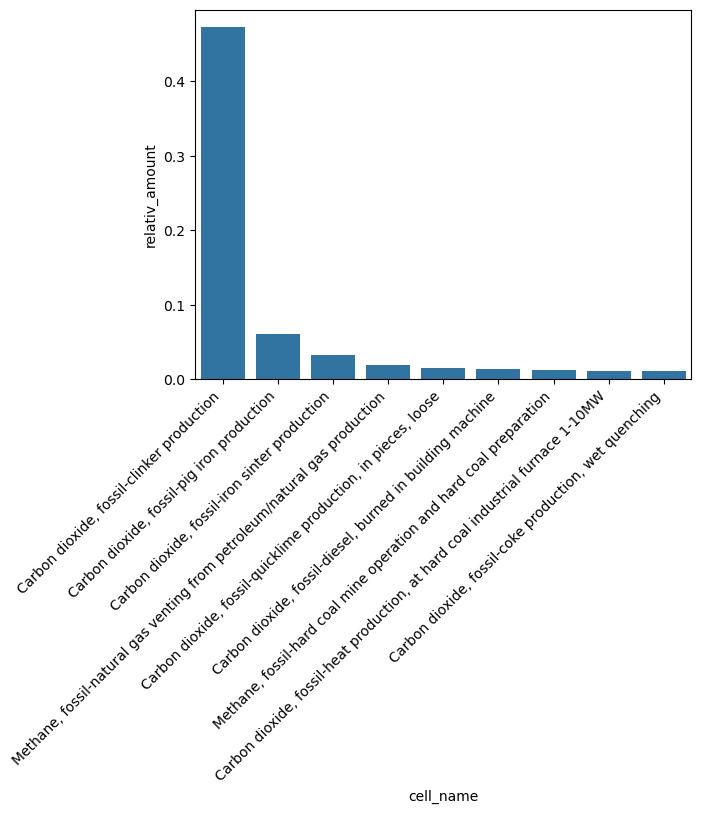

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.barplot(data=h_df,x = 'cell_name',y = 'relativ_amount',errorbar=None)

plt.xticks(rotation=45, ha='right');


### AC des flux élémentaires agrégés

AC des flux élémentaires agrégés sur l'ensemble des procédés

On stocke la matrice de contribution dans une variable et on regarde à quoi elle ressemble :

In [66]:
contrib_mat =lca.characterized_inventory # matrice d'inventaire caractérisé ie matrice de contribution
print(contrib_mat)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21368 stored elements and shape (3238, 25414)>
  Coords	Values
  (50, 5)	9.213880685838001e-08
  (50, 11)	8.20829491379092e-06
  (50, 12)	0.00010482082822996388
  (50, 22)	9.386476893263494e-10
  (50, 50)	9.79438282853415e-07
  (50, 54)	0.00046231406811714606
  (50, 70)	5.8199312760650037e-11
  (50, 92)	8.637247972729461e-05
  (50, 105)	0.00041252481102166914
  (50, 158)	1.991416368497488e-05
  (50, 168)	4.009092535897374e-22
  (50, 185)	0.00013158603362556316
  (50, 213)	8.544281083449291e-06
  (50, 248)	1.1297834108841477e-06
  (50, 252)	1.0075655515853293e-05
  (50, 255)	1.786807165549472e-13
  (50, 261)	2.355494457644247e-07
  (50, 274)	2.867291056587066e-07
  (50, 300)	2.607300437599351e-09
  (50, 304)	1.0853772358158864e-06
  (50, 308)	0.0056097673755723275
  (50, 310)	0.00017468578802471674
  (50, 329)	1.3184207263194e-09
  (50, 347)	8.185670719011738e-05
  (50, 421)	8.138578694763057e-10
  :	:
  (3214, 13300)	2.82384

In [123]:
contrib_EF = contrib_mat.sum(axis=1) # On fait la somme de chacune des lignes pour avoir la contribution des EF agrégés sur l'ensemble des procédés
print(f"Dimensions de la matrice : {contrib_EF.shape}")
print(f"Somme des éléments de la matrice : {contrib_EF[:,0].sum() : .0f}") # On vérifie que la somme des éléments vaut bien le score total
nodes = [bd.get_node(id = i) for i in lca.dicts.biosphere.keys()] # On crée la liste des noeuds (flux élémentaires) à partir de leurs indices
contrib_EF_dict = {str(nodes[i]):float(contrib_EF[i,0]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des EF pour clés et la contribution en valeur
print(f"Somme des éléments du dictionnaire : {sum(contrib_EF_dict.values()) : .0f}") # On vérifie que la somme des éléments vaut bien le score total

Dimensions de la matrice : (3238, 1)
Somme des éléments de la matrice :  562
Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

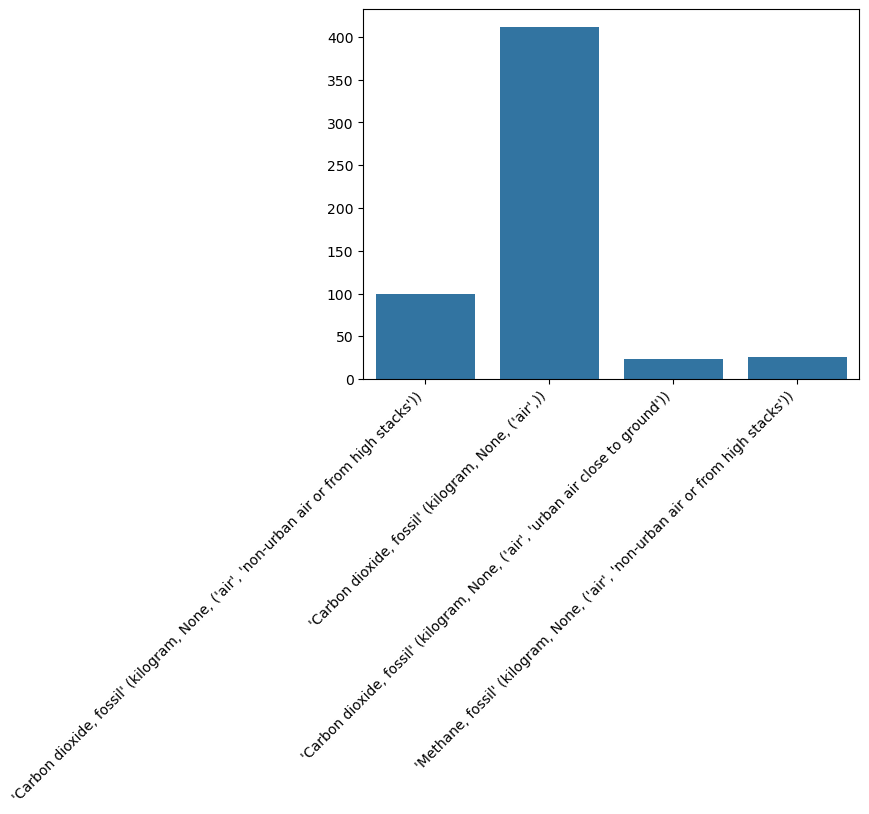

In [ ]:
cutoff = 0.005 # en pourcentage du score d'impact
fig, ax = plt.subplots()
sns.barplot( { k : v for k,v in contrib_EF_dict.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

On peut vérifier nos résultats : 

Regardons la masse de méthane dans notre inventaire et comparons le produit de celle-ci avec un facteur de caractérisation usuel (~29 kgCO2 eq / kg CH4).  

Pour trouver la masse, on fait le même travail que précédemment, mais avec la matrice d'inventaire et non de contribution.

In [ ]:
G =lca.inventory # matrice d'inventaire

G_EF = G.sum(axis=1) # On fait la somme de chacune des lignes pour avoir la contribution à l'inventaire des EF agrégés sur l'ensemble des procédés
nodes = [bd.get_node(id = i) for i in lca.dicts.biosphere.keys()] # On crée la liste des noeuds () à partir de leur indice
G_EF = {str(nodes[i]) : float(G_EF[i,0]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des EF pour clés et la contribution en valeur
G_EF = { k : v for k,v in G_EF.items() if v!=0} # On supprime les valeurs nulles

On affiche désormais toutes les quantités de méthane de notre inventaire :

In [ ]:
methanes = {k : G_EF[k] for k in G_EF.keys() if 'Methane' in str(k)}
print(methanes)
contrib_methanes = {k : contrib_EF_dict[k] for k in contrib_EF_dict.keys() if 'Methane' in str(k)}
methanes

{"'Methane, fossil' (kilogram, None, ('air',))": 0.014280051643986717, "'Methane, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 4.8181316102342664e-05, "'Methane, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.0001439893082704478, "'Methane, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.00670776133219881, "'Methanesulfonic acid' (kilogram, None, ('air', 'urban air close to ground'))": 6.141556213275472e-10, "'Methane, non-fossil' (kilogram, None, ('air',))": 5.854291050262766e-06, "'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.006933479536745133, "'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.8529966877286822}


{"'Methane, fossil' (kilogram, None, ('air',))": 0.4255455280959894,
 "'Methane, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.0014358031830903845,
 "'Methane, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.0038877113233020903,
 "'Methane, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 0.18110955596936784,
 "'Methanesulfonic acid' (kilogram, None, ('air', 'urban air close to ground'))": 0.0,
 "'Methane, non-fossil' (kilogram, None, ('air',))": 0.0001580658583570947,
 "'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))": 0.2066176849051799,
 "'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))": 25.419300643529894}

In [118]:
masse_methane = sum(methanes.values())
CF_usuel = 29
resultat_attendu = masse_methane*CF_usuel
resultat_obtenu = sum(contrib_methanes.values())
print('attendu : ',resultat_attendu,'\n','obtenu : ',resultat_obtenu)

attendu :  25.552364167364555 
 obtenu :  26.23805499286518


Le résultat attendu est proche de celui obtenu. Vérifions le facteur de caractérisation utilisé pour notre méthode.

In [100]:
methane_ids = {node : node.id for node in biodb if node['name'] == 'Methane, fossil' } # On regarde l'indice des noeuds correspondant au méthane
methane_ids


{'Methane, fossil' (kilogram, None, ('air', 'low population density, long-term')): 190810763489570916,
 'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')): 190810763636371495,
 'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground')): 190810763594428437,
 'Methane, fossil' (kilogram, None, ('air',)): 190810763095306276}

In [ ]:
C = lca.characterization_matrix # On regarde dans la matrice de caractérisation la valeur qui nous intéresse
C[lca.dicts.biosphere[list(methane_ids.values())[3]],lca.dicts.biosphere[list(methane_ids.values())[3]]]


np.float64(29.799999237060547)

### AC des procédés

Pour trouver la contribution directe de chacun des procédés, la démarche est exactement la même, mais en agrégeant suivant les colonnes.

In [143]:
contrib_process = contrib_mat.sum(axis=0)
print(f"Dimensions de la matrice : {contrib_process.shape}")
print(f"Somme des éléments de la matrice : {contrib_process[0,:].sum() : .0f}") # On vérifie que la somme des éléments vaut bien le score total
nodes = [bd.get_node(id = i) for i in lca.dicts.activity.keys()] # On crée la liste des noeuds (ici des procédés) à partir de leurs indices
contrib_process_dict = {nodes[i]:float(contrib_process[0,i]) for i in range(len(nodes))} # On crée un dictionnaire avec le nom des procédés pour clés et la contribution en valeur
print(f"Somme des éléments du dictionnaire : {sum(contrib_EF_dict.values()) : .0f}") # On vérifie que la somme des éléments vaut bien le score total

Dimensions de la matrice : (1, 25414)
Somme des éléments de la matrice :  562
Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

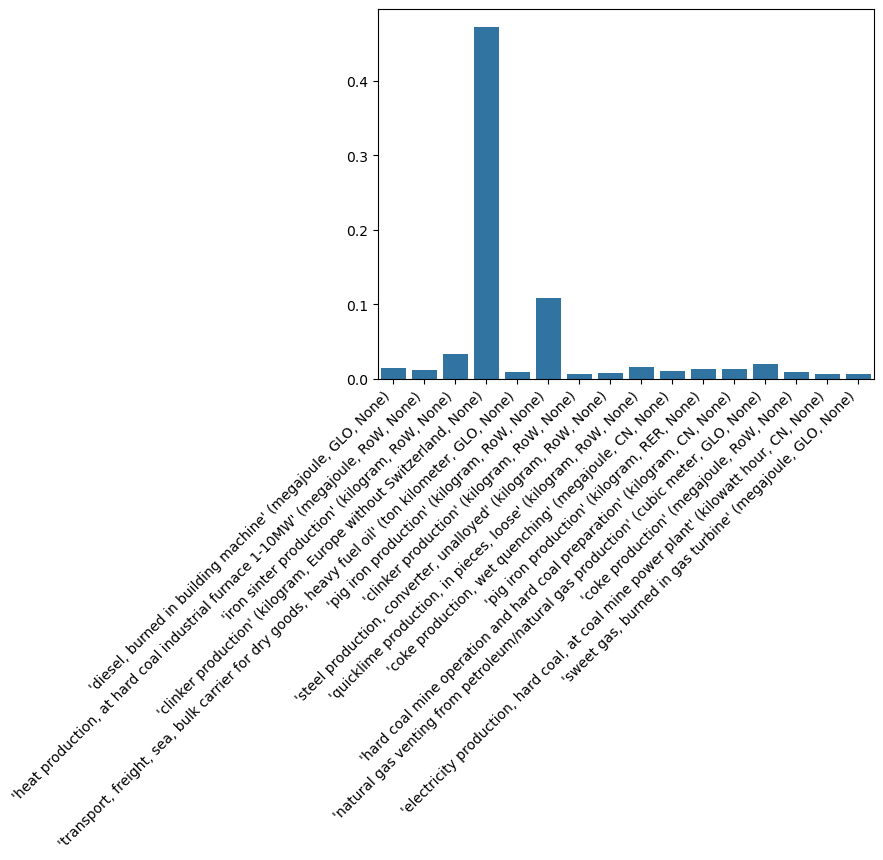

In [144]:
cutoff = 0.005 # en pourcentage du score d'impact
fig, ax = plt.subplots()
sns.barplot( { k : v/s for k,v in contrib_process_dict.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

### AC de groupes de procédés

On peut grouper les procédés et évaluer la contribution directe de ces groupes aux indicateurs d'impacts. Le crtière pour les grouper est libre, il est courant de regrouper les procédés par étape du cycle de vie, ou par secteur de l'économie.

On commence par reprendre le dicitonnaire des contributions par procédés, et on agrège selon le critère du secteur économique.

In [194]:
filtered_contrib_process_dict = { k : v for k,v in contrib_process_dict.items() if 'classifications' in list(k.keys())} # On ne garde que les activités qui ont une classification (deux activités posent problèmes seulement)
sectors = set([act['classifications'][0][1] for act in list(filtered_contrib_process_dict.keys())]) # On détermine l'ensemble des secteurs, avec une fois chaque secteur
contrib_sectors = {sector : sum([i[1] for i in filtered_contrib_process_dict.items() if i[0]['classifications'][0][1]==sector]) for sector in sectors} # Pour chaque secteur, on somme la liste des contributions qui en font partie

On vérifie que la somme des contributions vaut le score total :

In [195]:
print(f"Somme des éléments du dictionnaire : {sum(contrib_sectors.values()) : .0f}")

Somme des éléments du dictionnaire :  562


On peut désormais tracer les contributions, en se fixant un cut-off :

In [198]:
sectors

{'0',
 '0111:Growing of cereals (except rice), leguminous crops and oil seeds',
 '0112:Growing of rice',
 '0113:Growing of vegetables and melons, roots and tubers',
 '0114:Growing of sugar cane',
 '0116:Growing of fibre crops',
 '0119:Growing of other non-perennial crops',
 '0121:Growing of grapes',
 '0122:Growing of tropical and subtropical fruits',
 '0123:Growing of citrus fruits',
 '0124:Growing of pome fruits and stone fruits',
 '0125:Growing of other tree and bush fruits and nuts',
 '0126:Growing of oleaginous fruits',
 '0127:Growing of beverage crops',
 '0128:Growing of spices, aromatic, drug and pharmaceutical crops',
 '0129:Growing of other perennial crops',
 '0130:Plant propagation',
 '0141:Raising of cattle and buffaloes',
 '0144:Raising of sheep and goats',
 '0145:Raising of swine/pigs',
 '0146:Raising of poultry',
 '0149:Raising of other animals',
 '0161:Support activities for crop production',
 '0162:Support activities for animal production',
 '0163:Post-harvest crop activ

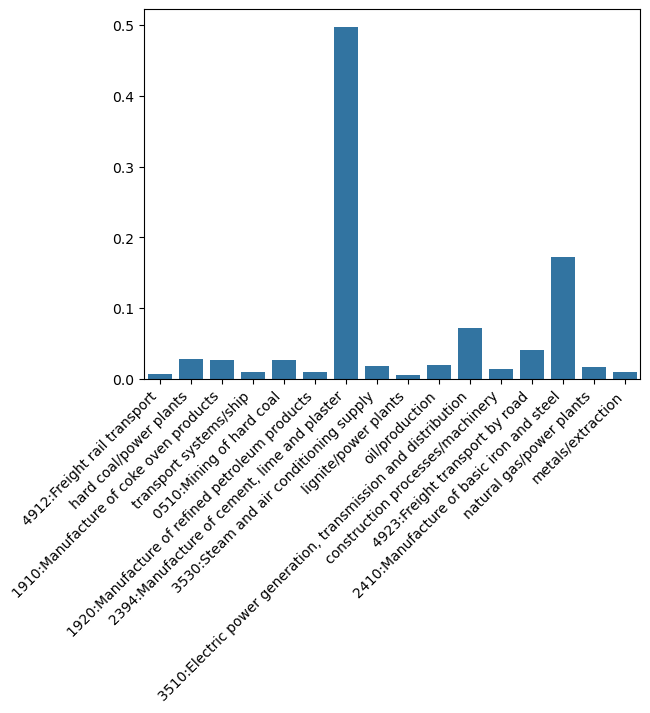

In [197]:
cutoff = 0.005 # en pourcentage du score d'impact

fig, ax = plt.subplots()
sns.barplot( { k : v/s for k,v in contrib_sectors.items() if v > s*cutoff},errorbar=None) # On fait ici une compréhension de dictionnaire pour ne tracer que les valeurs au dessus du cut-off
plt.xticks(rotation=45, ha='right');

Nous nous sommes ici servis du fait que les secteurs de l'économie sont une donnée présente dans les procédés ecoinvent. Si vous souhaitez grouper les activités que vous créez par étapes du cycle de vie, pensez à l'indiquer en métadonnées, dans un champ que vous pouvez créer, ou bien faite des macro-procédés par étape de cycle de vie.

### AC des procédés de premier niveau

Pour avoir les contributions des procédés de premier niveau, on réalise successivement l'ACV de chacun d'eux. On récupère donc les activités avec lesquelles notre béton a des échanges (flux intermédiaires).

In [214]:
first_tier_processes ={p.id : p.amount for p in list(beton_A.technosphere())} # On récupère les identifiants des procédés et la valeurs de flux intermédiaires associés



In [ ]:
contrib_first_processes = {}
for p,a in first_tier_processes.items() :
    lca = bc.LCA(demand={p : a},method=gwp100)
    lca.lci()
    lca.lcia()
    contrib_first_processes[bd.get_node()] = lca.score


UnknownObject: 

In [226]:
lca = bc.LCA(demand = {bd.get_node({id == list(first_tier_processes.items())[0][0]}) : 1},method=gwp100)

TypeError: get_node() takes 0 positional arguments but 1 was given

## AC indirecte